In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras import layers
from keras.applications import MobileNetV2
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
import pandas as pd
import numpy as np
import os
import cv2

In [3]:
dir_path_real = "/content/drive/MyDrive/Monkeypox Skin Lesion/Original Images/Original Images"
dir_path_aug = "/content/drive/MyDrive/Monkeypox Skin Lesion/Augmented Images/Augmented Images"
input_shape = (224,224,3)
target_size = (224,224)
target_names = [
    "Monkey Pox",
    "Others"
]

In [4]:
#Some exploration on dataset
def display_random_image(df,path):
  plt.figure(figsize=(20,5))
  plt.suptitle('Some Random Images from Dataset',fontsize=16)

  for i in range(5):
   row = df.sample().iloc[0]
   class_path = f"{path}/{row['Class']}"
   img_name = row['Filename']
   img = plt.imread(f"{class_path}/{img_name}")
   plt.subplot(1,5,i+1)
   plt.axis("off")
   plt.title(row['Class'])
   plt.imshow(img)

In [5]:
def summarize(path):
  dataset = pd.DataFrame(columns=["Class","Filename"])

  for dirpath,dirnames,filenames in os.walk(path):

      class_name=dirpath.split(os.path.sep)[-1]
      for filename in filenames:
        row = {
            "Class" : class_name,
            "Filename" : filename
        }
        dataset = dataset.append(row, ignore_index = True)

  image_count = len(dataset)
  labels = dataset["Class"].unique().tolist()

  labels_string=""
  sample_count_string=""
  for label in labels:
    labels_string+=f"{label} "
    sample_count_string+=f"{label} ({dataset['Class'].value_counts()[label]}) "

  print(f"""Total image count : {image_count}
Classes : {labels_string}
Image count for each class : {sample_count_string}
""")

  display_random_image(dataset,path)

  return dataset

Total image count : 228
Classes : Monkey Pox Others 
Image count for each class : Monkey Pox (102) Others (126) 



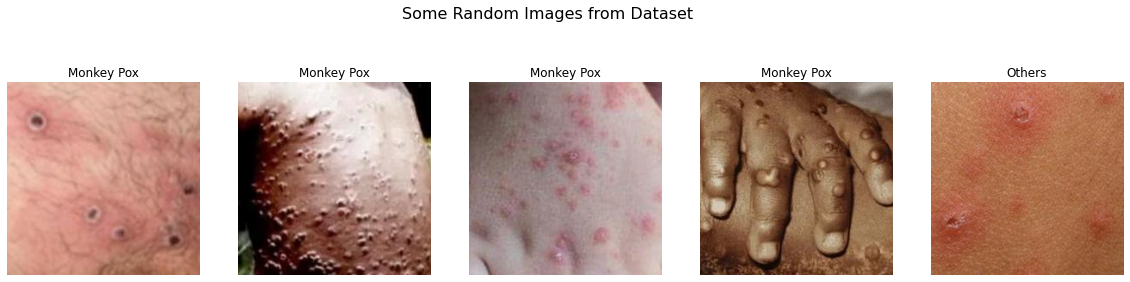

In [6]:
df_real = summarize(dir_path_real)

Total image count : 3192
Classes : Others_augmented Monkeypox_augmented 
Image count for each class : Others_augmented (1764) Monkeypox_augmented (1428) 



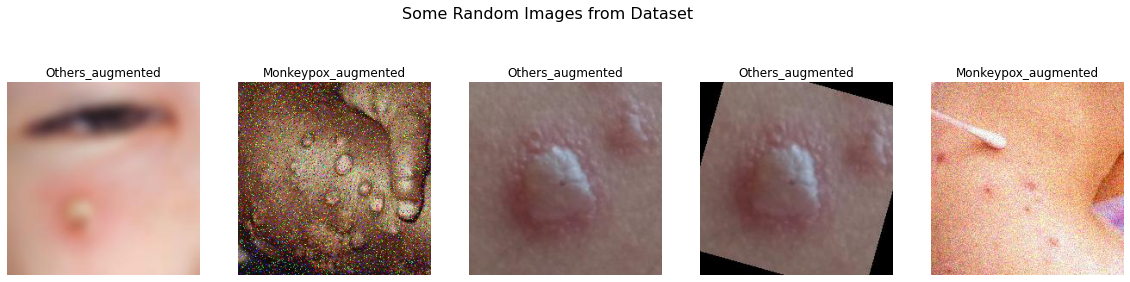

In [7]:
df_aug = summarize(dir_path_aug)

In [8]:
#We are not applying any augmentation on train set since it is already augmented
train_datagen = ImageDataGenerator(
    rescale = 1./255
)
#We are using real images for test and validation set
val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.4
)

In [9]:
train_gen = train_datagen.flow_from_directory(
    dir_path_aug,
    target_size=target_size,
    class_mode="binary",
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    dir_path_real,
    target_size=target_size,
    subset="training",
    class_mode="binary",
    shuffle=True
)
test_gen = val_datagen.flow_from_directory(
    dir_path_real,
    target_size= target_size,
    subset="validation",
    class_mode="binary",
    shuffle=True
)

Found 3192 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [10]:
mobilenet = MobileNetV2(weights = "imagenet",
                        input_shape = input_shape,
                        include_top = False)

mobilenet.trainable = False

inputs = layers.Input(shape=input_shape)
x = mobilenet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1)(x)
outputs = layers.Activation("sigmoid")(x)

model = Model(inputs,outputs)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                

In [11]:
model.compile("adam", loss='binary_crossentropy', metrics=['accuracy']) 

callbacks=[ModelCheckpoint(filepath="monkeypox_classifier.h5",monitor="val_accuracy",mode="max",save_best_only=True,save_weights_only=False,verbose=1),
          EarlyStopping(monitor="val_accuracy",patience=10,verbose=1,mode="max")]

In [12]:
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 50,
    callbacks = callbacks,
    use_multiprocessing=True,
    workers=12
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.7378
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to monkeypox_classifier.h5
100/100 [==============================] - 64s 497ms/step - loss: 0.5167 - accuracy: 0.7378 - val_loss: 0.3375 - val_accuracy: 0.8333
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8456
Epoch 2: val_accuracy improved from 0.83333 to 0.88406, saving model to monkeypox_classifier.h5
100/100 [==============================] - 24s 217ms/step - loss: 0.3790 - accuracy: 0.8456 - val_loss: 0.2658 - val_accuracy: 0.8841
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8684
Epoch 3: val_accuracy improved from 0.88406 to 0.92029, saving model to monkeypox_classifier.h5
100/100 [==============================] - 23s 217ms/step - loss: 0.3265 - accuracy: 0.8684 - val_loss: 0.2122 - val_accuracy: 0.9203
Epoch 4/50
100/100 [=====

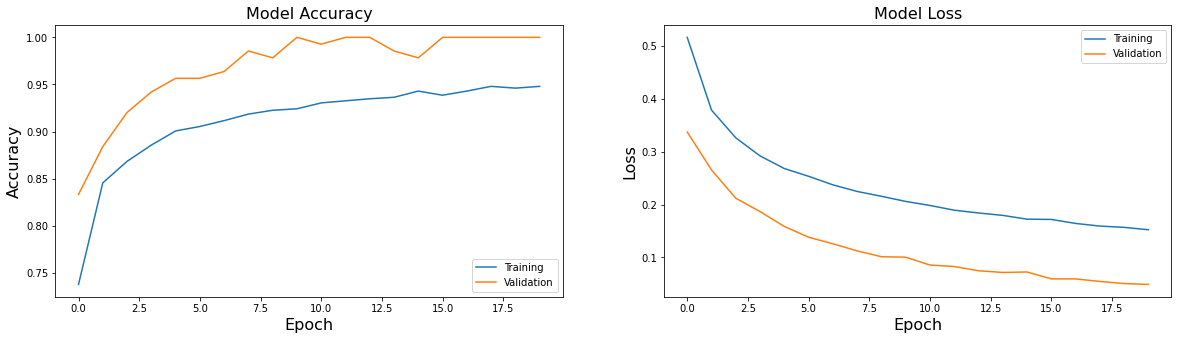

In [13]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],label="Training")
plt.plot(history.history["val_accuracy"],label="Validation")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Model Accuracy", fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training")
plt.plot(history.history["val_loss"],label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.title("Model Loss", fontsize=16)

plt.show()

In [14]:
loss,accuracy = model.evaluate(test_gen)
print(f"""Test Loss : {loss:.2f}
Test Accuracy : {(accuracy*100):.2f}%""")

3/3 [==============================] - 8s 4s/step - loss: 0.0539 - accuracy: 0.9889
Test Loss : 0.05
Test Accuracy : 98.89%


In [17]:
x_test,y_test=test_gen.next()
y_pred = model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test,y_pred,target_names=target_names))

1/1 [==============================] - 1s 747ms/step
              precision    recall  f1-score   support

  Monkey Pox       1.00      0.89      0.94         9
      Others       0.94      1.00      0.97        17

    accuracy                           0.96        26
   macro avg       0.97      0.94      0.96        26
weighted avg       0.96      0.96      0.96        26



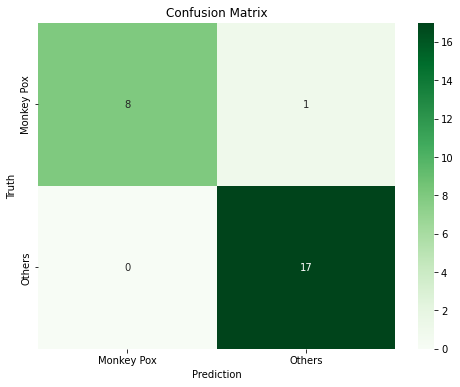

In [18]:
conf = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k')

ax = sns.heatmap(conf, cmap='Greens', annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [42]:
def predict_sample(path):
  img=load_img(path,target_size=target_size)
  img=img_to_array(img,dtype=np.uint8)
  img=np.array(img) / 255.0
  p=model.predict(img.reshape(1,224,224,3))
  predicted_class = np.squeeze(np.where(p > 0.5, 1, 0))[()]

  return img,p,predicted_class

class_labels = {
    0 : "Monkey Pox",
    1 : "Others"
}

1/1 [==============================] - 0s 25ms/step


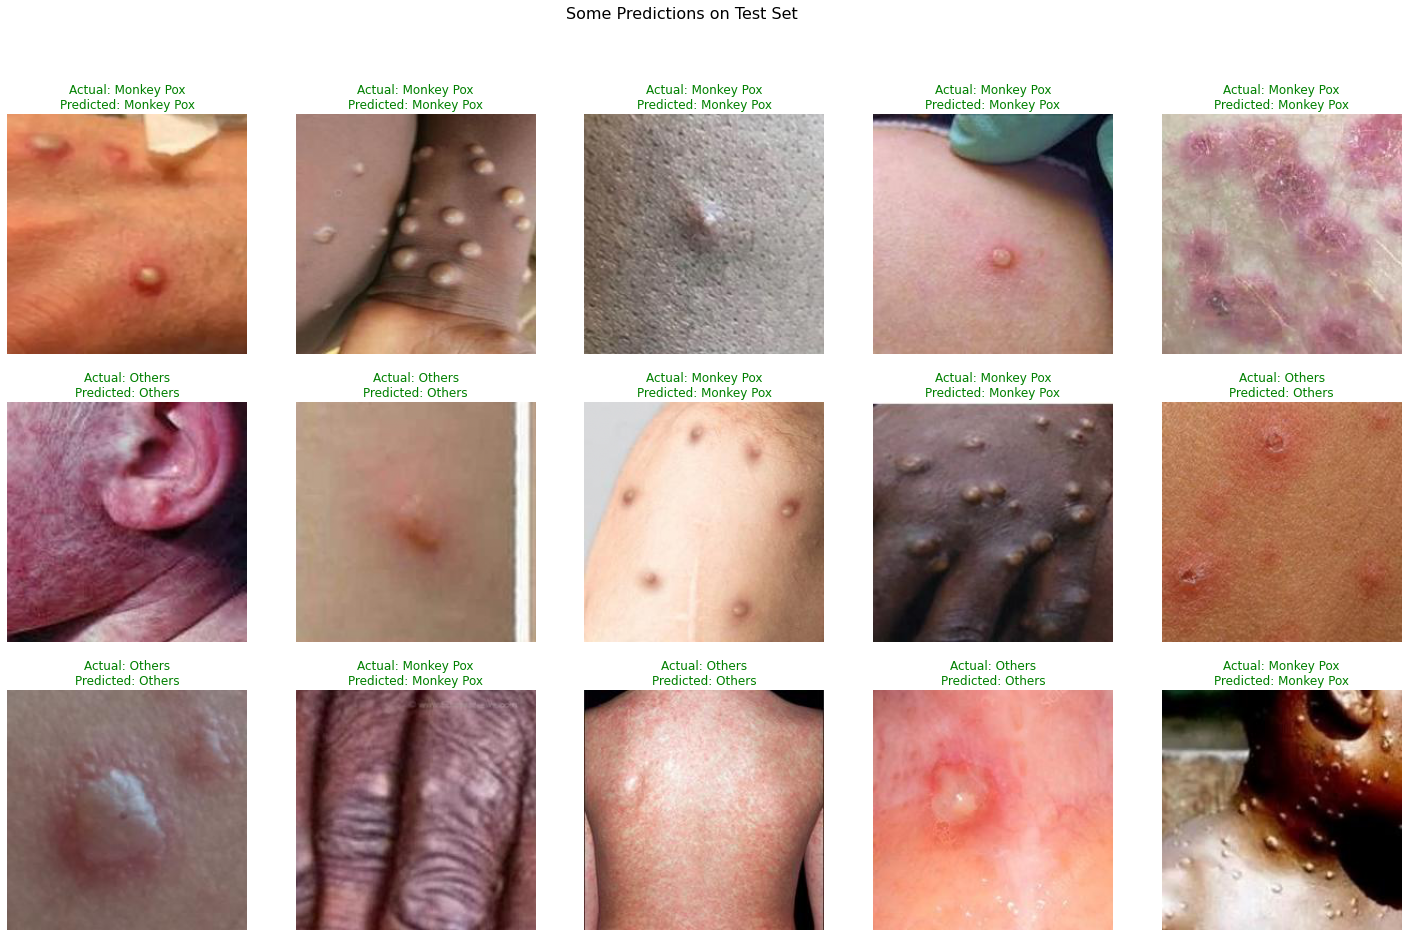

In [43]:
plt.figure(figsize=(25,15))
plt.suptitle("Some Predictions on Test Set",fontsize=16)

for i in range(15):
  random_row = df_real.sample().iloc[0]
  img_path = f"{dir_path_real}/{random_row['Class']}/{random_row['Filename']}"
  
  img,p,predicted_class = predict_sample(img_path)
  
  predicted = class_labels[predicted_class]

  plt.subplot(3,5,i+1)
  plt.axis("off")
  if predicted == random_row['Class'] :
    title_color = "g"
  else :
    title_color = "r"
  plt.title(f"Actual: {random_row['Class']}\nPredicted: {predicted}",c=title_color)
  plt.imshow(img)

In [44]:
tflite_model = tf.keras.models.load_model('monkeypox_classifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("monkeypox_classifier.tflite", "wb").write(tflite_save)

8869680